<a href="https://colab.research.google.com/github/Abiben100/Housing-Price-prediction/blob/main/Linear_regression_Housing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Loading dataset file
file_path = '/content/drive/My Drive/HousingPricePrediction/Housing.csv'
housing_data = pd.read_csv(file_path)

In [ ]:
# Preprocess the data
# Converting binary categorical variables to numeric
for col in housing_data.columns:
    if housing_data[col].dtype == 'object' and housing_data[col].nunique() <= 2:
        housing_data[col] = housing_data[col].map({'yes': 1, 'no': 0})

# Maping furnishing status
furnishing_mapping = {'furnished': 3, 'semi-furnished': 2, 'unfurnished': 1}
housing_data['furnishingstatus'] = housing_data['furnishingstatus'].map(furnishing_mapping)

In [ ]:
# Fill missing values with the mean
housing_data.fillna(housing_data.mean(), inplace=True)

In [ ]:
# Log-transform the target variable 'price'
housing_data['log_price'] = np.log(housing_data['price'])

In [ ]:
#Feauture engineering the correlated variables
# Combine 'bedrooms' and 'bathrooms' into a single feature 'rooms_combined'
housing_data['rooms_combined'] = housing_data['bedrooms'] + housing_data['bathrooms']

# Drop the original 'bedrooms' and 'bathrooms' columns
housing_data.drop(['bedrooms', 'bathrooms'], axis=1, inplace=True)

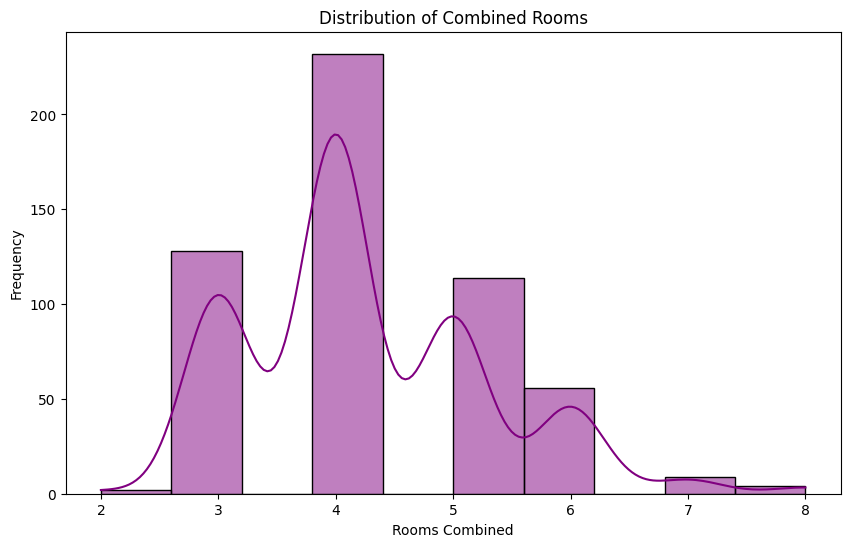

In [ ]:
# Visualize the distribution of the new 'rooms_combined' feature
plt.figure(figsize=(10, 6))
sns.histplot(housing_data['rooms_combined'], kde=True, bins=10, color='purple')
plt.title('Distribution of Combined Rooms')
plt.xlabel('Rooms Combined')
plt.ylabel('Frequency')
plt.show()

In [ ]:
correlations = housing_data.corr()
print(correlations['rooms_combined'])

price               0.511809
area                0.202072
stories             0.448996
mainroad            0.011983
guestroom           0.118653
basement            0.118779
hotwaterheating     0.065340
airconditioning     0.204951
parking             0.185196
prefarea            0.087030
furnishingstatus    0.157336
log_price           0.498867
rooms_combined      1.000000
Name: rooms_combined, dtype: float64


<ipython-input-10-8cdf97297e59>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rooms_combined', y='price', data=housing_data, palette='coolwarm')


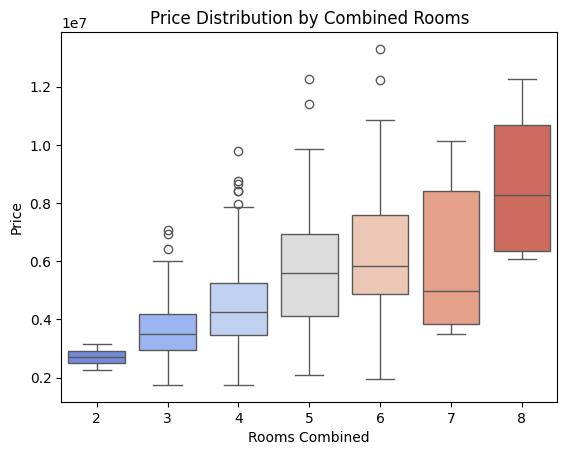

In [ ]:
sns.boxplot(x='rooms_combined', y='price', data=housing_data, palette='coolwarm')
plt.title('Price Distribution by Combined Rooms')
plt.xlabel('Rooms Combined')
plt.ylabel('Price')
plt.show()

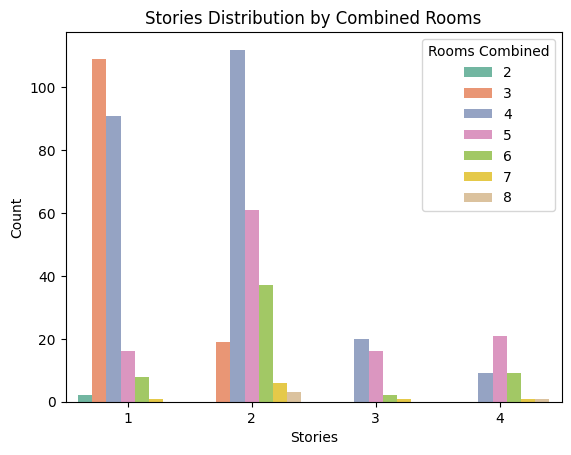

In [ ]:
sns.countplot(x='stories', hue='rooms_combined', data=housing_data, palette='Set2')
plt.title('Stories Distribution by Combined Rooms')
plt.xlabel('Stories')
plt.ylabel('Count')
plt.legend(title='Rooms Combined')
plt.show()

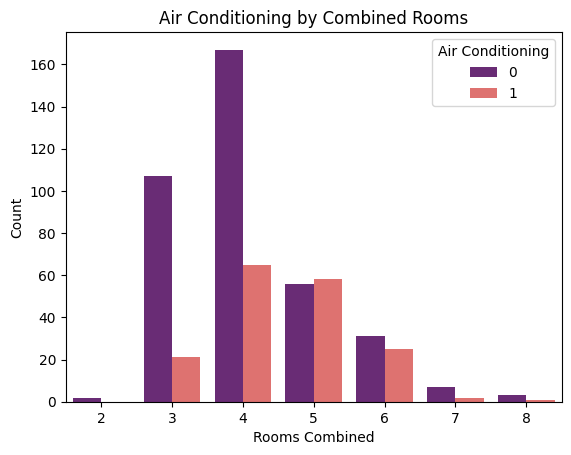

In [ ]:
sns.countplot(x='rooms_combined', hue='airconditioning', data=housing_data, palette='magma')
plt.title('Air Conditioning by Combined Rooms')
plt.xlabel('Rooms Combined')
plt.ylabel('Count')
plt.legend(title='Air Conditioning')
plt.show()

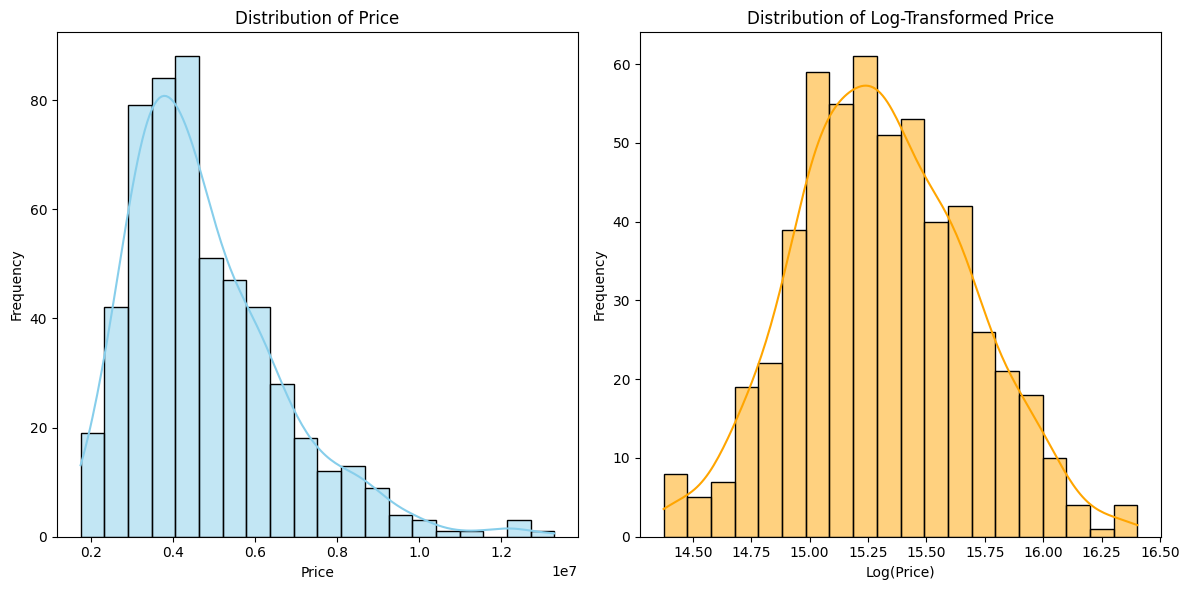

In [ ]:
# Visualize distributions of original and log-transformed 'price'
plt.figure(figsize=(12, 6))

# Original price distribution
plt.subplot(1, 2, 1)
sns.histplot(housing_data['price'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-transformed price distribution
plt.subplot(1, 2, 2)
sns.histplot(housing_data['log_price'], kde=True, bins=20, color='orange')
plt.title('Distribution of Log-Transformed Price')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

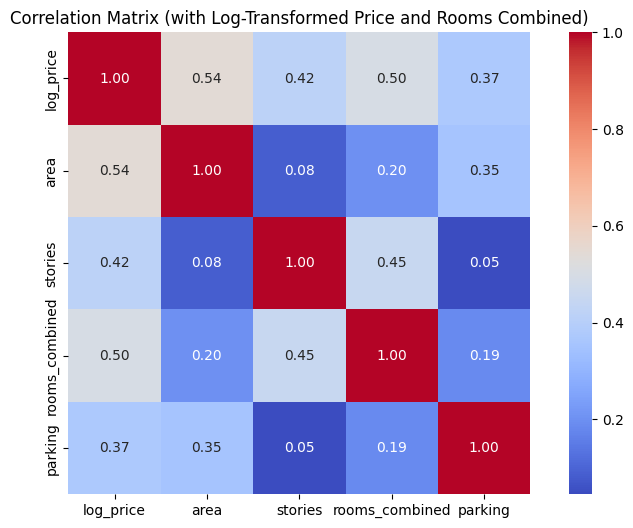

In [ ]:
# Generate a Correlation matrix
# List of columns to analyze for correlation
columns_with_log = ['log_price', 'area', 'stories', 'rooms_combined', 'parking']

# Plot the correlation matrix including 'rooms_combined'
correlation_matrix_log = housing_data[columns_with_log].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_log, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix (with Log-Transformed Price and Rooms Combined)')
plt.show()

In [ ]:
# Calculate VIF (excluding original 'price' and 'log_price')
X_vif = housing_data.drop(['price', 'log_price'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("VIF (after combining 'bedrooms' and 'bathrooms' into 'rooms_combined'):")
print(vif_data)

VIF (after combining 'bedrooms' and 'bathrooms' into 'rooms_combined'):
             feature        VIF
0               area   8.373907
1            stories   7.881132
2           mainroad   7.135571
3          guestroom   1.461628
4           basement   2.026901
5    hotwaterheating   1.087707
6    airconditioning   1.737038
7            parking   1.943030
8           prefarea   1.485813
9   furnishingstatus   7.389774
10    rooms_combined  15.951388


In [ ]:
# Function to create a regression summary and calculate MSE and R2
def regression_summary(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions and residual variance
    y_pred = model.predict(X_test)
    residual_var = mean_squared_error(y_test, y_pred)

    # Calculate standard error for coefficients
    X_train_const = np.c_[np.ones(X_train.shape[0]), X_train]  # Add intercept
    XTX_inv = np.linalg.inv(X_train_const.T @ X_train_const)
    se_beta = np.sqrt(np.diag(XTX_inv * residual_var))

    # Calculate t-values and p-values
    t_values = model.coef_ / se_beta[1:]  # Exclude intercept
    p_values = [2 * (1 - t.cdf(abs(t_val), df=len(y_train) - X_train.shape[1] - 1)) for t_val in t_values]

    # Confidence intervals
    ci_lower = model.coef_ - 1.96 * se_beta[1:]
    ci_upper = model.coef_ + 1.96 * se_beta[1:]

    # Create a summary table
    summary_df = pd.DataFrame({
        "coef": model.coef_,
        "std err": se_beta[1:],
        "t": t_values,
        "P>|t|": p_values,
        "[0.025": ci_lower,
        "0.975]": ci_upper
    }, index=X.columns)

    # Calculate MSE and R² for predictions
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return summary_df, model, y_test, y_pred, mse, r2

# Define features (X)
X = housing_data.drop(['price', 'log_price'], axis=1)

# Regression summary for log-transformed price
log_summary, log_model, log_y_test, log_y_pred, log_mse, log_r2 = regression_summary(X, housing_data['log_price'])
print("Summary for Log-Transformed Price (after combining rooms):")
print(log_summary)
print(f"\nMSE for Log-Transformed Price: {log_mse}")
print(f"R² for Log-Transformed Price: {log_r2}")

Summary for Log-Transformed Price (after combining rooms):
                      coef   std err         t         P>|t|    [0.025  \
area              0.000049  0.000006  7.791085  5.173639e-14  0.000037   
stories           0.079287  0.017468  4.539050  7.371077e-06  0.045050   
mainroad          0.115956  0.037896  3.059822  2.355283e-03  0.041679   
guestroom         0.057604  0.035691  1.613971  1.072777e-01 -0.012350   
basement          0.101017  0.029836  3.385745  7.760131e-04  0.042539   
hotwaterheating   0.138314  0.056608  2.443353  1.495842e-02  0.027362   
airconditioning   0.158269  0.029602  5.346627  1.467634e-07  0.100249   
parking           0.040705  0.015672  2.597268  9.723707e-03  0.009988   
prefarea          0.115643  0.030643  3.773888  1.836101e-04  0.055583   
furnishingstatus  0.059074  0.017027  3.469416  5.750053e-04  0.025701   
rooms_combined    0.078403  0.013918  5.633188  3.227651e-08  0.051124   

                    0.975]  
area              0.000

Training MSE: 0.0404, R²: 0.6755
Testing MSE: 0.0645, R²: 0.6659


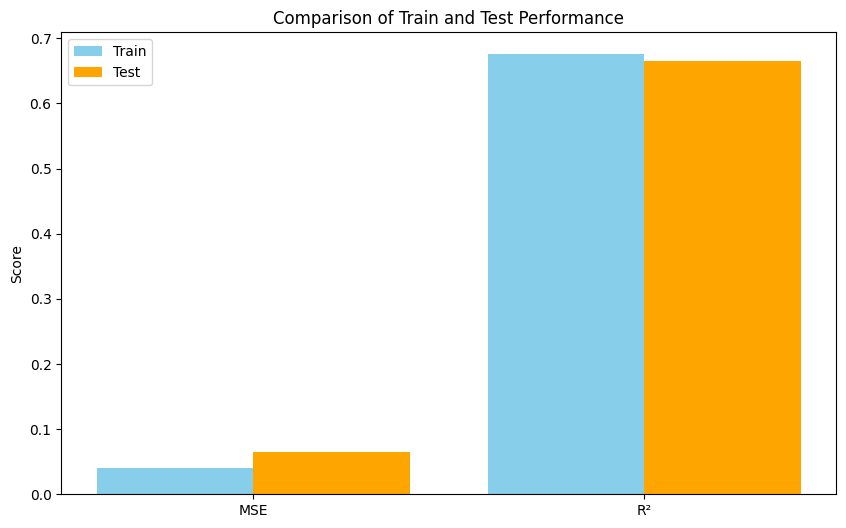

In [ ]:
X = housing_data.drop(['price', 'log_price'], axis=1)
y = housing_data['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)  # Predictions on training set
y_test_pred = model.predict(X_test)    # Predictions on test set

# Calculate metrics for training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

# Visualize the results
metrics = ['MSE', 'R²']
train_scores = [train_mse, train_r2]
test_scores = [test_mse, test_r2]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
plt.bar(x - 0.2, train_scores, width=0.4, label='Train', color='skyblue')
plt.bar(x + 0.2, test_scores, width=0.4, label='Test', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Comparison of Train and Test Performance')
plt.legend()
plt.show()

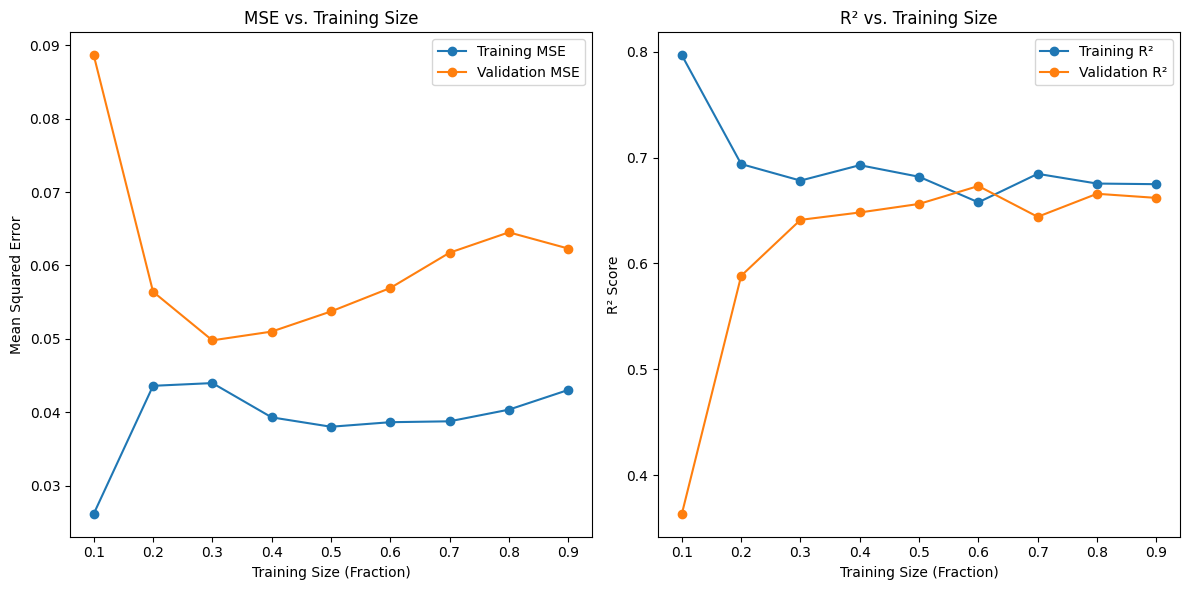

In [ ]:
# Function to generate training and validation metrics for different training sizes
def training_validation_curve(X, y, model):
    train_sizes = np.linspace(0.1, 0.9, 9)  # 9 evenly spaced fractions between 10% and 90% (avoiding 1.0)
    train_mse = []
    val_mse = []
    train_r2 = []
    val_r2 = []

    for train_size in train_sizes:
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, random_state=42)

        model.fit(X_train, y_train)  # Train the model

        # Predict on training and validation sets
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate MSE and R² for training and validation
        train_mse.append(mean_squared_error(y_train, y_train_pred))
        val_mse.append(mean_squared_error(y_val, y_val_pred))
        train_r2.append(r2_score(y_train, y_train_pred))
        val_r2.append(r2_score(y_val, y_val_pred))

    return train_sizes, train_mse, val_mse, train_r2, val_r2

# Define features and target
X = housing_data.drop(['price', 'log_price'], axis=1)
y = housing_data['log_price']

# Initialize the model
model = LinearRegression()

# Generate the training-validation curve data
train_sizes, train_mse, val_mse, train_r2, val_r2 = training_validation_curve(X, y, model)

# Plot MSE and R² curves
plt.figure(figsize=(12, 6))

# MSE Curve
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mse, label='Training MSE', marker='o')
plt.plot(train_sizes, val_mse, label='Validation MSE', marker='o')
plt.xlabel('Training Size (Fraction)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Training Size')
plt.legend()

# R² Curve
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_r2, label='Training R²', marker='o')
plt.plot(train_sizes, val_r2, label='Validation R²', marker='o')
plt.xlabel('Training Size (Fraction)')
plt.ylabel('R² Score')
plt.title('R² vs. Training Size')
plt.legend()

plt.tight_layout()
plt.show()

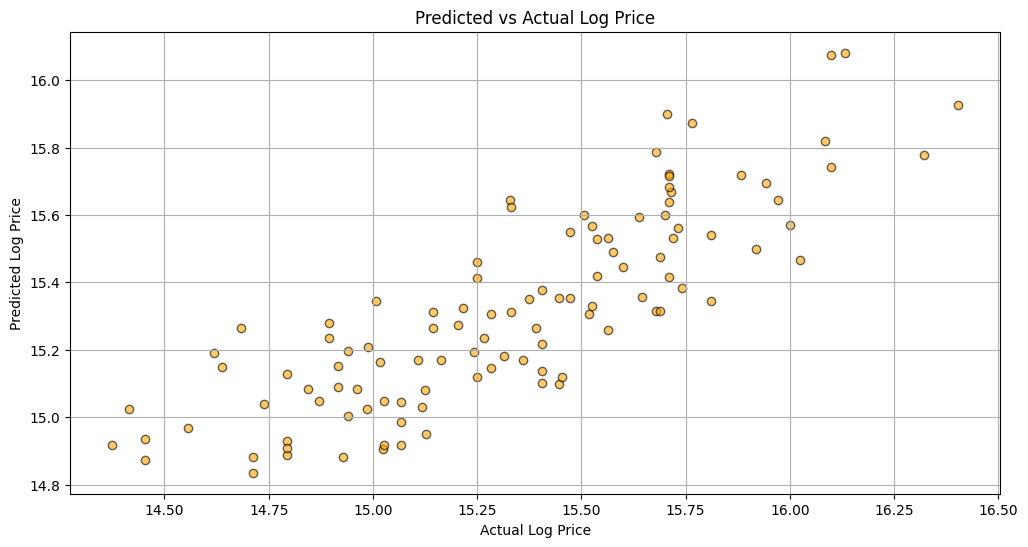

In [ ]:
# Visualize predictions for log price
plt.figure(figsize=(12, 6))
plt.scatter(log_y_test, log_y_pred, alpha=0.6, color='orange', edgecolor='k')
plt.title('Predicted vs Actual Log Price')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.grid()
plt.show()

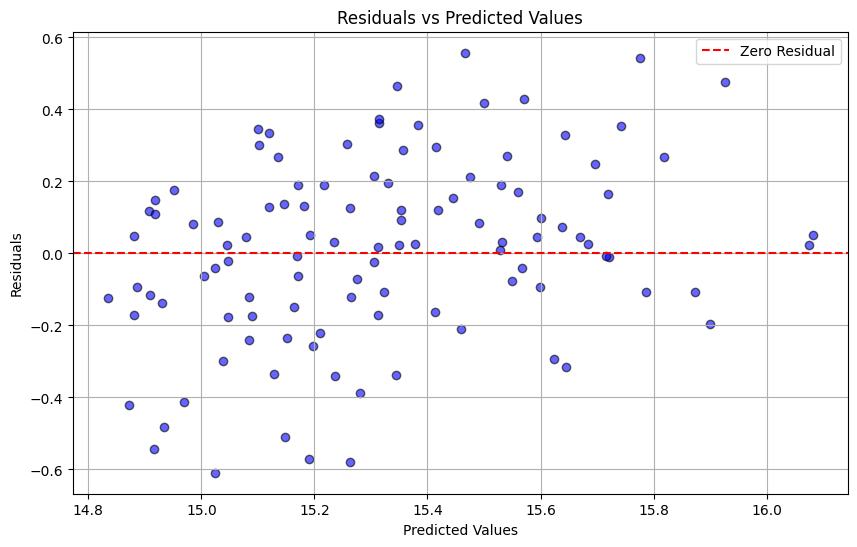

In [ ]:
# Residual analysis
residuals = y_test - y_test_pred

# Plotting Residuals vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6, color='blue', edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.legend()
plt.show()
